# Test on a single example

## import libraries and load dataset

### mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### install dependancies

In [ ]:
# !pip install accelerate -q
# !pip install transformers -q

###  import libraries

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel, Kosmos2ForConditionalGeneration, AutoModelForVision2Seq # AutoModelForCausalLM

import requests
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch
import requests
# from torchvision.transforms import *
import random
import pandas as pd
from numpy.random import choice
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import cv2
import numpy as np
import torchvision.transforms as T
import sys

In [ ]:
def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)


def draw_entity_boxes_on_image(image, entities, show=False, save_path=None):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    elif isinstance(image, str):
        if os.path.exists(image):
            pil_img = Image.open(image).convert("RGB")
            image = np.array(pil_img)[:, :, [2, 1, 0]]
            image_h = pil_img.height
            image_w = pil_img.width
        else:
            raise ValueError(f"invaild image path, {image}")
    elif isinstance(image, torch.Tensor):
        image_tensor = image.cpu()
        reverse_norm_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        reverse_norm_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])[:, None, None]
        image_tensor = image_tensor * reverse_norm_std + reverse_norm_mean
        pil_img = T.ToPILImage()(image_tensor)
        image_h = pil_img.height
        image_w = pil_img.width
        image = np.array(pil_img)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, (start, end), bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])
    if save_path:
        pil_image.save(save_path)
    if show:
        pil_image.show()

    return new_image


# # (The same image from the previous code example)
# url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
# image = Image.open(requests.get(url, stream=True).raw)

# # From the previous code example
# entities = [('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]

### reproducibility in inference

In [ ]:
GLOBAL_SEED = 10

np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
torch.use_deterministic_algorithms(True)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


### load a test image

In [ ]:
# url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"
illusionless_fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions"

data_df = pd.read_csv("/content/drive/MyDrive/Final_project/FashionMnist/df_data.csv")
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

illusion_image_name = "FashionMnist_1.jpg"
illusion_image_path = os.path.join(fashion_mnist_images_folder, "ill_images", illusion_image_name)
illusion_image = Image.open(illusion_image_path) # .convert("RGB")
# "/content/drive/MyDrive/Final_project/FashionMnist/ill_images/FashionMnist_1.jpg"

raw_image_name = "FashionMnist_1.jpg"
raw_image_path = f"{fashion_mnist_images_folder}/raw_images/{raw_image_name}"
raw_image = Image.open(raw_image_path) # .convert("RGB")
# "/content/drive/MyDrive/Final_project/FashionMnist/raw_images/FashionMnist_1.jpg"

illusionless_image_name = "FashionMnist_1.png"
illusionless_image_path = f"{illusionless_fashion_mnist_images_folder}/illusionless_images/{illusionless_image_name}"
illusionless_image = Image.open(illusionless_image_path) # .convert("RGB")
# "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions/illusionless_images/FashionMnist_1.png"

# illusion_image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
print(illusion_image_path)
print("/content/drive/MyDrive/Final_project/FashionMnist/ill_images/FashionMnist_1.jpg")

/content/drive/MyDrive/Final_Project/FashionMnist/ill_images/FashionMnist_1.jpg
/content/drive/MyDrive/Final_project/FashionMnist/ill_images/FashionMnist_1.jpg


In [ ]:
print("The configuration and caption(Pprompt) for generating photo:")
data_df.iloc[0]

The configuration and caption(Pprompt) for generating photo:


image_name                                           FashionMnist_1
Pprompt              Two friends hiking on a mountain during sunset
Nprompt                                                 low quality
illusion_strength                                               1.5
label                                                             9
Name: 0, dtype: object

raw fashion mnist image (FashionMnist_1.jpg):


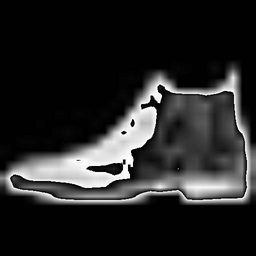

In [ ]:
print("raw fashion mnist image (FashionMnist_1.jpg):")
raw_image.resize((256, 256), Image.Resampling.LANCZOS)

illusion fashion mnist image (FashionMnist_1.jpg):


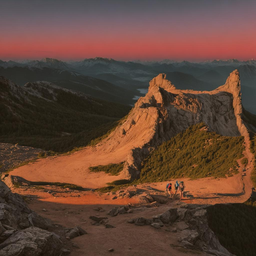

In [ ]:
print("illusion fashion mnist image (FashionMnist_1.jpg):")
illusion_image.resize((256, 256), Image.Resampling.LANCZOS)

illusionless fashion mnist image generated with same caption (FashionMnist_1.png):


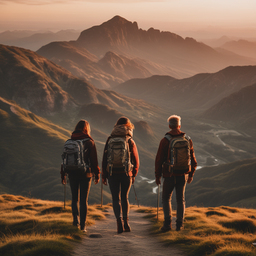

In [ ]:
print("illusionless fashion mnist image generated with same caption (FashionMnist_1.png):")
illusionless_image.resize((256, 256), Image.Resampling.LANCZOS)

## conditional Generation

### load model and processor

In [ ]:
model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/191k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### inference on conditional generation model with prompt (say that it contains illuison)

In [ ]:
prompt = "<grounding> An image of a hidden illusioned object from fashion mnist dataset that\
    contains following 10 classes: 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot'. We just\
    want to find The hidden object in a single word. The hidden object is:"

# prompt = "<grounding> This image contains latent and hidden object in it. It was generated by an optical illusion diffuion model. \
#     In fact, it contains a illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word one of the 10 classes above. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'."

# prompt = "This image contains latent and hidden object in it. It was generated by an optical illusion diffuion model. \
#     In fact, it contains a illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word one of the 10 classes above. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'."

image = illusion_image
inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=64,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(">>    generated_text:")
generated_text

>>    generated_text:


'<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of a hidden illusioned object from fashion mnist dataset that contains following 10 classes: \'T-shirt/top\', \'Trouser\', \'Pullover\', \'Dress\', \'Coat\', \'Sandal\', \'Shirt\', \'Sneaker\', \'Bag\', \'Ankle boot\'. We just want to find The hidden object in a single word. The hidden object is: \'top\'.<phrase> The image</phrase><object><patch_index_0000><patch_index_1023></object> shows a group of people walking on a mountain trail at sunset.'

In [ ]:
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
print(">>    processed_text:")
print(processed_text)

caption, entities = processor.post_process_generation(generated_text)
print(">>    caption:")
print(caption)

print(">>    entities:")
print(entities)

print(">>    answer:")
print(caption.split("The hidden object is:")[1].strip())

print(">>    extracted answer:")
print(caption.split("The hidden object is:")[1].strip().split("'")[1])

>>    processed_text:
<grounding> An image of a hidden illusioned object from fashion mnist dataset that contains following 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. We just want to find The hidden object in a single word. The hidden object is: 'top'.<phrase> The image</phrase><object><patch_index_0000><patch_index_1023></object> shows a group of people walking on a mountain trail at sunset.
>>    caption:
An image of a hidden illusioned object from fashion mnist dataset that contains following 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. We just want to find The hidden object in a single word. The hidden object is: 'top'. The image shows a group of people walking on a mountain trail at sunset.
>>    entities:
[('The image', (294, 303), [(0.015625, 0.015625, 0.984375, 0.984375)])]
>>    answer:
'top'. The image shows a group of people walk

### inference inference on conditional generation model with prompt (say that it may contains illuison)



In [ ]:
prompt = "<grounding> This image may have a hidden illusioned object from fashion mnist dataset that\
    contains following 11 classes: 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'No hidden object' . We just\
    want to find The hidden object in a single word. The hidden object is: "

# prompt = "<grounding> This image may contains latent and hidden object in it or not. Either It was generated by an optical illusion diffuion model \
#     that contains an illusioned hidden object, or tt was generated by a text to image stable illusion model that does not contain an illusioned hidden object . \
#     If it contains a hidden object, it contains an illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
#     Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
#     For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

# prompt = "This image may contains latent and hidden object in it or not. Either It was generated by an optical illusion diffuion model \
#     that contains an illusioned hidden object, or tt was generated by a text to image stable illusion model that does not contain an illusioned hidden object . \
#     If it contains a hidden object, it contains an illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
#     Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
#     For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

image = illusionless_image
inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=64,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(">>    generated_text:")
generated_text

>>    generated_text:


'<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> This image may have a hidden illusioned object from fashion mnist dataset that contains following 11 classes: \'T-shirt/top\', \'Trouser\', \'Pullover\', \'Dress\', \'Coat\', \'Sandal\', \'Shirt\', \'Sneaker\', \'Bag\', \'Ankle boot\', \'No hidden object\'. We just want to find The hidden object in a single word. The hidden object is: \'backpack\'.<phrase> The image</phrase><object><patch_index_0000><patch_index_1023></object> is a beautiful mountain landscape with a group of people walking towards the sunset.'

In [ ]:
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
print(">>    processed_text:")
print(processed_text)

caption, entities = processor.post_process_generation(generated_text)
print(">>    caption:")
print(caption)

print(">>    entities:")
print(entities)

print(">>    answer:")
print(caption.split("The hidden object is:")[1].strip())

print(">>    extracted answer:")
print(caption.split("The hidden object is:")[1].strip().split("'")[1])

>>    processed_text:
<grounding> This image may have a hidden illusioned object from fashion mnist dataset that contains following 11 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'No hidden object'. We just want to find The hidden object in a single word. The hidden object is: 'backpack'.<phrase> The image</phrase><object><patch_index_0000><patch_index_1023></object> is a beautiful mountain landscape with a group of people walking towards the sunset.
>>    caption:
This image may have a hidden illusioned object from fashion mnist dataset that contains following 11 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'No hidden object'. We just want to find The hidden object in a single word. The hidden object is: 'backpack'. The image is a beautiful mountain landscape with a group of people walking towards the sunset.
>>    entities:
[('The image', (327, 

In [ ]:
prompt = "<grounding> This image may have a hidden illusioned object from fashion mnist dataset that\
    contains following 11 classes: 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'No hidden object' . We just\
    want to find The hidden object in a single word. The hidden object is: "

# prompt = "<grounding> This image may contains latent and hidden object in it or not. Either It was generated by an optical illusion diffuion model \
#     that contains an illusioned hidden object, or tt was generated by a text to image stable illusion model that does not contain an illusioned hidden object . \
#     If it contains a hidden object, it contains an illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
#     Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
#     For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

# prompt = "This image may contains latent and hidden object in it or not. Either It was generated by an optical illusion diffuion model \
#     that contains an illusioned hidden object, or tt was generated by a text to image stable illusion model that does not contain an illusioned hidden object . \
#     If it contains a hidden object, it contains an illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
#     Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
#     For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

image = illusion_image
inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=64,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(">>    generated_text:")
generated_text

>>    generated_text:


'<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> This image may have a hidden illusioned object from fashion mnist dataset that contains following 11 classes: \'T-shirt/top\', \'Trouser\', \'Pullover\', \'Dress\', \'Coat\', \'Sandal\', \'Shirt\', \'Sneaker\', \'Bag\', \'Ankle boot\', \'No hidden object\'. We just want to find The hidden object in a single word. The hidden object is: \'Fashion\'.<phrase> The image</phrase><object><patch_index_0000><patch_index_1023></object> is a beautiful sunset on a mountain top.'

In [ ]:
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
print(">>    processed_text:")
print(processed_text)

caption, entities = processor.post_process_generation(generated_text)
print(">>    caption:")
print(caption)

print(">>    entities:")
print(entities)

print(">>    answer:")
print(caption.split("The hidden object is:")[1].strip())

print(">>    extracted answer:")
print(caption.split("The hidden object is:")[1].strip().split("'")[1])

>>    processed_text:
<grounding> This image may have a hidden illusioned object from fashion mnist dataset that contains following 11 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'No hidden object'. We just want to find The hidden object in a single word. The hidden object is: 'Fashion'.<phrase> The image</phrase><object><patch_index_0000><patch_index_1023></object> is a beautiful sunset on a mountain top.
>>    caption:
This image may have a hidden illusioned object from fashion mnist dataset that contains following 11 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'No hidden object'. We just want to find The hidden object in a single word. The hidden object is: 'Fashion'. The image is a beautiful sunset on a mountain top.
>>    entities:
[('The image', (326, 335), [(0.015625, 0.015625, 0.984375, 0.984375)])]
>>    answer:
'Fashion'. The image is a

### giving raw image to detect suitable class the conditional generation model

In [ ]:
# prompt = "<grounding> This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer that says which class this image belongs to in a single word. \
#     The object in this image is: "

prompt = "<grounding> This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: \
    'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer that says which class this image belongs to in a single word. \
    For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. \
    The object in this image is: "

image = raw_image.convert("RGB")
inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=64,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(">>    generated_text:")
generated_text

>>    generated_text:


'<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: \'T-shirt/top\', \'Trouser\', \'Pullover\', \'Dress\', \'Coat\', \'Sandal\', \'Shirt\', \'Sneaker\', \'Bag\', \'Ankle boot\'. Please just generate answer that says which class this image belongs to in a single word. For example, if you detect a \'T-shirt/top\' just generate \'T-shirt/top\'. The object in this image is: \'Trousers\'.<phrase> The dataset</phrase><object><patch_index_0000><patch_index_1023></object> has 10 objects.'

In [ ]:
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
print(">>    processed_text:")
print(processed_text)

caption, entities = processor.post_process_generation(generated_text)
print(">>    caption:")
print(caption)

print(">>    entities:")
print(entities)

print(">>    answer:")
print(caption.split("The object in this image is:")[1].strip())

print(">>    extracted answer:")
print(caption.split("The object in this image is:")[1].strip().split("'")[1])

>>    processed_text:
<grounding> This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. Please just generate answer that says which class this image belongs to in a single word. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. The object in this image is: 'Trousers'.<phrase> The dataset</phrase><object><patch_index_0000><patch_index_1023></object> has 10 objects.
>>    caption:
This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. Please just generate answer that says which class this image belongs to in a single word. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. The object in this image is: 'Trousers'. The dataset has 10 objects.
>>    ent

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
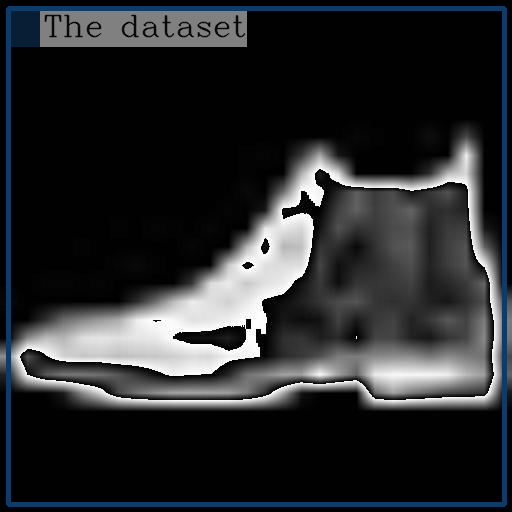

In [ ]:
# Draw the bounding bboxes
new_image = draw_entity_boxes_on_image(image, entities, show=True, save_path="/content/bbox_image.jpg")
new_image

In [ ]:
# prompt = "<grounding> This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer that says which class this image belongs to in a single word. \
#     The object in this image is: "

prompt = "<grounding> An image of "

image = raw_image.convert("RGB")
inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=64,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(">>    generated_text:")
generated_text

>>    generated_text:


'<image>. the, to and of as in I that\' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a shoe</phrase><object><patch_index_0256><patch_index_0831></object> and<phrase> a building</phrase><object><patch_index_0338><patch_index_0733></object>, with<phrase> a black background</phrase><object><patch_index_0000><patch_index_1023></object>'

In [ ]:
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
print(">>    processed_text:")
print(processed_text)

caption, entities = processor.post_process_generation(generated_text)
print(">>    caption:")
print(caption)

print(">>    entities:")
print(entities)

print(">>    answer:")
print(caption.split("An image of")[1].strip())

# print(">>    extracted answer:")
# print(caption.split("The object in this image is:")[1].strip().split("'")[1])

>>    processed_text:
<grounding> An image of<phrase> a shoe</phrase><object><patch_index_0256><patch_index_0831></object> and<phrase> a building</phrase><object><patch_index_0338><patch_index_0733></object>, with<phrase> a black background</phrase><object><patch_index_0000><patch_index_1023></object>
>>    caption:
An image of a shoe and a building, with a black background
>>    entities:
[('a shoe', (12, 18), [(0.015625, 0.265625, 0.984375, 0.796875)]), ('a building', (23, 33), [(0.578125, 0.328125, 0.921875, 0.703125)]), ('a black background', (40, 58), [(0.015625, 0.015625, 0.984375, 0.984375)])]
>>    answer:
a shoe and a building, with a black background


## question answering

### load model

In [ ]:
# https://medium.com/@csv610/visual-question-answering-using-kosmos-2-25418ee3b16b
class Kosmos2QuestionAnswering:
    def __init__(self):
        model_name = "microsoft/kosmos-2-patch14-224"
        self.model = AutoModelForVision2Seq.from_pretrained(model_name).to("cuda")
        self.processor = AutoProcessor.from_pretrained(model_name)

    def get_answer(self, image, question):
        # Convert OpenCV image to PIL image
        image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        prompt = "<grounding> Question: " + question + " Answer: "

        inputs = self.processor(text=prompt, images=image_pil, return_tensors="pt").to("cuda")

        generated_ids = self.model.generate(
            pixel_values=inputs["pixel_values"],
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            image_embeds=None,
            image_embeds_position_mask=inputs["image_embeds_position_mask"],
            use_cache=True,
            max_new_tokens=128,
        )

        generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        processed_text, _= self.processor.post_process_generation(generated_text, cleanup_and_extract=True)

        return processed_text

In [ ]:
vqa = Kosmos2QuestionAnswering()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### inference on conditional generation model with prompt (say that it contains illuison)

In [ ]:
question = "This image contains latent and hidden object in it. It was generated by an optical illusion diffuion model. \
    In fact, it contains a illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
    'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer in a single word one of the 10 classes above. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'."
# image_path = illusion_image_path
image_path = "/content/drive/MyDrive/Final_project/FashionMnist/ill_images/FashionMnist_1.jpg"

# Load OpenCV image
image_cv2 = cv2.imread(image_path)

answer = vqa.get_answer(image_cv2, question)

print(">>    answer:")
print(answer)
print('>>    answer.split("Answer:")[1]:')
print(answer.split("Answer:")[1].strip())

>>    answer:
Question: This image contains latent and hidden object in it. It was generated by an optical illusion diffuion model. In fact, it contains a illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. Please just generate answer in a single word one of the 10 classes above. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. Answer: T-shirt
>>    answer.split("Answer:")[1]:
T-shirt


### inference inference on conditional generation model with prompt (say that it may contains illuison)

In [ ]:
# question = "This image may contains latent and hidden object in it or not. Either It was generated by an optical illusion diffuion model \
#     that contains an illusioned hidden object, or tt was generated by a text to image stable illusion model that does not contain an illusioned hidden object . \
#     If it contains a hidden object, it contains an illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
#     Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
#     For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

question = "The image may contains latent and hidden object in it or not. Either it contains an illusioned hidden object, or it does not contain an illusioned hidden object. \
    If it contains a hidden object, the hidden object is from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
    'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer in a single word. If it does not contain a hidden object just generate 'no' . \
    Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
    For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. if you do not detect any hidden obeject just generate 'no' ."

# image_path = illusionless_image_path
image_path = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions/illusionless_images/FashionMnist_1.png"

# Load OpenCV image
image_cv2 = cv2.imread(image_path)

answer = vqa.get_answer(image_cv2, question)

print(">>    answer:")
print(answer)
print('>>    answer.split("Answer:")[1]:')
print(answer.split("Answer:")[1].strip())

>>    answer:
Question: The image may contains latent and hidden object in it or not. Either it contains an illusioned hidden object, or it does not contain an illusioned hidden object. If it contains a hidden object, the hidden object is from fashion mnsit dataset. The dataset has 10 different objects. These objects are: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. if you do not detect any hidden obeject just generate 'no'. Answer: no
>>    answer.split("Answer:")[1]:
no


In [ ]:
# question = "This image may contains latent and hidden object in it or not. Either It was generated by an optical illusion diffuion model \
#     that contains an illusioned hidden object, or tt was generated by a text to image stable illusion model that does not contain an illusioned hidden object . \
#     If it contains a hidden object, it contains an illusioned hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
#     'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
#     Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
#     Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
#     For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

question = "The image may contains latent and hidden object in it or not. Either it contains an illusioned hidden object, or it does not contain an illusioned hidden object. \
    If it contains a hidden object, the hidden object is from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
    'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer in a single word. If it does not contain a hidden object just generate 'no' . \
    Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
    For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. if you do not detect any hidden obeject just generate 'no' ."

image = illusion_image

# image_path = illusion_image_path
image_path = "/content/drive/MyDrive/Final_project/FashionMnist/ill_images/FashionMnist_1.jpg"

# Load OpenCV image
image_cv2 = cv2.imread(image_path)

answer = vqa.get_answer(image_cv2, question)

print(">>    answer:")
print(answer)
print('>>    answer.split("Answer:")[1]:')
print(answer.split("Answer:")[1].strip())

>>    answer:
Question: The image may contains latent and hidden object in it or not. Either it contains an illusioned hidden object, or it does not contain an illusioned hidden object. If it contains a hidden object, the hidden object is from fashion mnsit dataset. The dataset has 10 different objects. These objects are: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. if you do not detect any hidden obeject just generate 'no'. Answer: yes
>>    answer.split("Answer:")[1]:
yes


### giving raw image to detect suitable class the conditional generation model

In [ ]:
question = "<grounding> This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: \
    'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer that says which class this image belongs to in a single word. \
    For example, if you detect a 'Ankle boot' just generate 'Ankle boot'. \
    if you do not detect any hidden obeject just generate 'no' ."

# image_path = raw_image_path
image_path = "/content/drive/MyDrive/Final_project/FashionMnist/raw_images/FashionMnist_40.jpg"

# Load OpenCV image
image_cv2 = cv2.imread(image_path)

answer = vqa.get_answer(image_cv2, question)

print(">>    answer:")
print(answer)
print('>>    answer.split("Answer:")[1]:')
print(answer.split("Answer:")[1].strip())

>>    answer:
Question: This image is from fashion mnist dataset. The dataset has 10 different objects. These objects are: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'. Please just generate answer that says which class this image belongs to in a single word. For example, if you detect a 'T-shirt/top' just generate 'Ankle boot'. if you do not detect any hidden obeject just generate 'no'. Answer: T-shirt
>>    answer.split("Answer:")[1]:
T-shirt


# Inference on whole dataset and batches of data

In [ ]:
# https://colab.research.google.com/drive/1bsa7pw2gVE8EPXVF5PptNXFPgZGYMu4o?usp=sharing
# https://colab.research.google.com/drive/1cF5pdwI1SDnO8fyRuMMc2P86xMEkyij6?usp=sharing

## Inference of visual question answering KOSMOS-2

In [ ]:
# https://medium.com/@csv610/visual-question-answering-using-kosmos-2-25418ee3b16b
class Kosmos2QuestionAnswering:
    def __init__(self):
        model_name = "microsoft/kosmos-2-patch14-224"
        self.model = AutoModelForVision2Seq.from_pretrained(model_name).to("cuda")
        self.processor = AutoProcessor.from_pretrained(model_name)

    def get_answer(self, image, question):
        # Convert OpenCV image to PIL image
        image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        prompt = "<grounding> Question: " + question + " Answer: "

        inputs = self.processor(text=prompt, images=image_pil, return_tensors="pt").to("cuda")

        generated_ids = self.model.generate(
            pixel_values=inputs["pixel_values"],
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            image_embeds=None,
            image_embeds_position_mask=inputs["image_embeds_position_mask"],
            use_cache=True,
            max_new_tokens=128,
        )

        generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        processed_text, _= self.processor.post_process_generation(generated_text, cleanup_and_extract=True)

        return processed_text

vqa = Kosmos2QuestionAnswering()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/191k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### prompt 1: just illusion images

In [ ]:
fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"
# illusionless_fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions"

data_df = pd.read_csv("/content/drive/MyDrive/Final_project/FashionMnist/df_data.csv")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

for i in range( len(data_df) ):
# for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.jpg" # 1-base in google drive
    illusion_image_path = os.path.join(fashion_mnist_images_folder, "ill_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = class_names[data_row.label]

    # question = "This image may contains latent and hidden object in it or not. Either It was generated by an optical illusion diffuion model \
    # that contains an illusion hidden object, or it was generated by a text to image stable illusion model that does not contain an illusion hidden object . \
    # If it contains a hidden object, it contains an illusion hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
    # 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    # Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
    # Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
    # For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

    question = "The image may contains latent and hidden object in it or not. Either it contains an illusion hidden object, or it does not contain an illusioned hidden object. \
    If it contains a hidden object, the hidden object is from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
    'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer in a single word. If it does not contain a hidden object just generate 'no' . \
    Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
    For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. if you do not detect any hidden obeject just generate 'no' ."


    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip()

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    if (label == 't-shirt/top'):
        if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
            correct_images += 1
    elif (label == 'ankle boot'):
        if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
            correct_images += 1
    elif (label in extracted_answer):
        correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")


accuracy up to 100 sample is 0.0
------------------------------------------
accuracy up to 200 sample is 0.0
------------------------------------------
accuracy up to 300 sample is 0.0
------------------------------------------
accuracy up to 400 sample is 0.0
------------------------------------------
accuracy up to 500 sample is 0.0
------------------------------------------
accuracy up to 600 sample is 0.0
------------------------------------------
accuracy up to 700 sample is 0.0
------------------------------------------
accuracy up to 800 sample is 0.0
------------------------------------------
accuracy up to 900 sample is 0.0
------------------------------------------
accuracy up to 1000 sample is 0.0
------------------------------------------
accuracy up to 1100 sample is 0.0
------------------------------------------
number of total_images: 1152
number of correct_images: 0
accuracy: 0.0


### prompt 2: just illusion images

In [ ]:
fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"
# illusionless_fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions"

data_df = pd.read_csv("/content/drive/MyDrive/Final_project/FashionMnist/df_data.csv")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

for i in range( len(data_df) ):
# for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.jpg" # 1-base in google drive
    illusion_image_path = os.path.join(fashion_mnist_images_folder, "ill_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = class_names[data_row.label]

    question = "This image may contains illusion of a hidden object in it or not. Either It was generated by an optical illusion diffuion model \
    that contains illusion of a hidden object, or it was generated by a text to image stable illusion model that does not contain an illusion hidden object . \
    If it contains illusion of a hidden object, it contains a hidden object from fashion mnsit dataset. The dataset has 10 different objects. These objects are: \
    'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer in a single word. If it does not contain a hidden object just generate 'no'. \
    Otherwise if it contains a hidden object just generate one of the 10 classes above in one word. \
    For example, if you detect a 'T-shirt/top' just generate 'T-shirt/top'. and if you do not detect any hidden obeject just generate 'no' ."

    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip()

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    if (label == 't-shirt/top'):
        if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
            correct_images += 1
    elif (label == 'ankle boot'):
        if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
            correct_images += 1
    elif (label in extracted_answer):
        correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

accuracy up to 100 sample is 0.0
------------------------------------------
accuracy up to 200 sample is 0.0
------------------------------------------
accuracy up to 300 sample is 0.0
------------------------------------------
accuracy up to 400 sample is 0.0
------------------------------------------
accuracy up to 500 sample is 0.0
------------------------------------------
accuracy up to 600 sample is 0.0
------------------------------------------
accuracy up to 700 sample is 0.0
------------------------------------------
accuracy up to 800 sample is 0.0
------------------------------------------
accuracy up to 900 sample is 0.0
------------------------------------------
accuracy up to 1000 sample is 0.0
------------------------------------------
accuracy up to 1100 sample is 0.0
------------------------------------------
number of total_images: 1152
number of correct_images: 0
accuracy: 0.0


### prompt 3: just illusion images

In [ ]:
fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"
# illusionless_fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions"

data_df = pd.read_csv("/content/drive/MyDrive/Final_project/FashionMnist/df_data.csv")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

for i in range( len(data_df) ):
# for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.jpg" # 1-base in google drive
    illusion_image_path = os.path.join(fashion_mnist_images_folder, "ill_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = class_names[data_row.label]

    question = "This image contains illusion of a hidden object in it. \
    The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer in a single word and select one of hidden objects mentioned. \
    For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'."

    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip()

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    if (label == 't-shirt/top'):
        if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
            correct_images += 1
    elif (label == 'ankle boot'):
        if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
            correct_images += 1
    elif (label in extracted_answer):
        correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

accuracy up to 100 sample is 15.0
------------------------------------------
accuracy up to 200 sample is 15.5
------------------------------------------
accuracy up to 300 sample is 17.0
------------------------------------------
accuracy up to 400 sample is 18.0
------------------------------------------
accuracy up to 500 sample is 17.8
------------------------------------------
accuracy up to 600 sample is 18.166666666666668
------------------------------------------
accuracy up to 700 sample is 18.714285714285715
------------------------------------------
accuracy up to 800 sample is 19.0
------------------------------------------
accuracy up to 900 sample is 18.666666666666668
------------------------------------------
accuracy up to 1000 sample is 18.5
------------------------------------------
accuracy up to 1100 sample is 18.818181818181817
------------------------------------------
number of total_images: 1152
number of correct_images: 213
accuracy: 18.489583333333336


prompt 3: just raw images

In [ ]:
fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"

data_df = pd.read_csv(f"{fashion_mnist_images_folder}/df_data.csv")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

for i in range( len(data_df) ):
# for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.jpg" # 1-base in google drive
    illusion_image_path = os.path.join(fashion_mnist_images_folder, "raw_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = class_names[data_row.label]

    question = "This image contains an object in it. \
    The objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    Please just generate answer in a single word and select one of the objects mentioned that is in the image. \
    For example, if you detect a 'T-shirt/top' generate 'T-shirt/top'."

    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip()

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    if (label == 't-shirt/top'):
        if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
            correct_images += 1
    elif (label == 'ankle boot'):
        if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
            correct_images += 1
    elif (label in extracted_answer):
        correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

accuracy up to 100 sample is 16.0
------------------------------------------
accuracy up to 200 sample is 18.0
------------------------------------------
accuracy up to 300 sample is 20.0
------------------------------------------
accuracy up to 400 sample is 20.25
------------------------------------------
accuracy up to 500 sample is 20.4
------------------------------------------
accuracy up to 600 sample is 20.166666666666664
------------------------------------------
accuracy up to 700 sample is 20.714285714285715
------------------------------------------
accuracy up to 800 sample is 20.875
------------------------------------------
accuracy up to 900 sample is 19.666666666666664
------------------------------------------
accuracy up to 1000 sample is 20.4
------------------------------------------
accuracy up to 1100 sample is 20.18181818181818
------------------------------------------
number of total_images: 1152
number of correct_images: 232
accuracy: 20.13888888888889


### prompt4: illusionless and illusion images with each other

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"
data_df = pd.read_csv(f"{fashion_mnist_images_folder}/df_data.csv")

for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.jpg" # 1-base in google drive
    illusion_image_path = os.path.join(fashion_mnist_images_folder, "ill_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = class_names[data_row.label]

    # question = "This image may contains illusion of a hidden object in it or not. \
    # The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    # Please just generate answer in a single word and select one of hidden objects mentioned. if you do not detect any hidden obeject just generate 'no' . \
    # For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no'."

    question = "This image may contains illusion of a hidden object in it or not. \
    The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'no hidden object' . \
    Please just generate answer in a single word and select one of hidden objects mentioned. \
    For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no hidden object'."

    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip()
    print(extracted_answer)

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    if (label == 't-shirt/top'):
        if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
            correct_images += 1
    elif (label == 'ankle boot'):
        if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
            correct_images += 1
    elif (label in extracted_answer):
        correct_images += 1
    # if (label == 'no'):
    #     if (label in extracted_answer):
    #         correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

yes
no hidden object
T-shirt
no hidden object
'Tshirt/Top'
Yes
yes
'Tshirt/Top'
yes
no hidden object
number of total_images: 10
number of correct_images: 2
accuracy: 20.0


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

illusionless_fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions"
data_df = pd.read_csv(f"{illusionless_fashion_mnist_images_folder}/df_data.csv")

# for i in range( len(data_df) ):
for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.png" # 1-base in google drive
    illusion_image_path = os.path.join(illusionless_fashion_mnist_images_folder, "illusionless_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = 'no'

    # question = "This image may contains illusion of a hidden object in it or not. \
    # The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' . \
    # Please just generate answer in a single word and select one of hidden objects mentioned. if you do not detect any hidden obeject just generate 'no' . \
    # For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no'."

    question = "This image may contains illusion of a hidden object in it or not. \
    The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'no hidden object' . \
    Please just generate answer in a single word and select one of hidden objects mentioned. \
    For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no hidden object'."


    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip()

    extracted_answer = extracted_answer.lower()
    print(extracted_answer)
    label = label.lower()

    # if (label == 't-shirt/top'):
    #     if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
    #         correct_images += 1
    # elif (label == 'ankle boot'):
    #     if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
    #         correct_images += 1
    # elif (label in extracted_answer):
    #     correct_images += 1
    if (label == 'no'):
        if (label in extracted_answer):
            correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
    # if ( (i+1+len(data_df)) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

t-shirt
t-shirt
t-shirt
no hidden object
t-shirt
no hidden object
no hidden object
no hidden object
t-shirt
t-shirt
number of total_images: 10
number of correct_images: 4
accuracy: 40.0


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"
data_df = pd.read_csv(f"{fashion_mnist_images_folder}/df_data.csv")

for i in range( len(data_df) ):
# for i in range( 10 ):
    illusion_image_name = f"FashionMnist_{i + 1}.jpg" # 1-base in google drive
    illusion_image_path = os.path.join(fashion_mnist_images_folder, "ill_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = class_names[data_row.label]

    question = "This image may contains illusion of a hidden object in it or not. \
    The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'no hidden object' . \
    Please just generate answer in a single word and select one of hidden objects mentioned. \
    For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no hidden object'."

    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip() # bias toward T-shirt

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    if (label == 't-shirt/top'):
        if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
            correct_images += 1
    elif (label == 'ankle boot'):
        if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
            correct_images += 1
    elif (label in extracted_answer):
        correct_images += 1
    # if (label == 'no'):
    #     if (label in extracted_answer):
    #         correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"accuracy on illusion images is {(correct_images / total_images) * 100}")
print("------------------------------------------")


illusionless_fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions"
data_df = pd.read_csv(f"{illusionless_fashion_mnist_images_folder}/df_data.csv")
ill_less_total_images = 0
ill_less_correct_images = 0

for i in range( len(data_df) ):
# for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.png" # 1-base in google drive
    illusion_image_path = os.path.join(illusionless_fashion_mnist_images_folder, "illusionless_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = 'no'

    question = "This image may contains illusion of a hidden object in it or not. \
    The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'no hidden object' . \
    Please just generate answer in a single word and select one of hidden objects mentioned. \
    For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no hidden object'."


    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip()

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    # if (label == 't-shirt/top'):
    #     if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
    #         correct_images += 1
    # elif (label == 'ankle boot'):
    #     if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
    #         correct_images += 1
    # elif (label in extracted_answer):
    #     correct_images += 1
    if (label == 'no'):
        if (label in extracted_answer):
            correct_images += 1
            ill_less_correct_images += 1

    total_images += 1
    ill_less_total_images += 1

    accuracy = (correct_images / total_images) * 100
    # if ( (i+1) % 100 == 0):
    if ( (i+1+len(data_df)) % 100 == 0):
        print(f"accuracy up to {i+1+len(data_df)} sample is {accuracy}")
        print("------------------------------------------")


print(f"accuracy on illusionless images is {(ill_less_correct_images / ill_less_total_images) * 100}")
print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

accuracy up to 100 sample is 4.0
------------------------------------------
accuracy up to 200 sample is 5.0
------------------------------------------
accuracy up to 300 sample is 6.0
------------------------------------------
accuracy up to 400 sample is 5.75
------------------------------------------
accuracy up to 500 sample is 5.2
------------------------------------------
accuracy up to 600 sample is 5.166666666666667
------------------------------------------
accuracy up to 700 sample is 5.428571428571429
------------------------------------------
accuracy up to 800 sample is 5.75
------------------------------------------
accuracy up to 900 sample is 5.333333333333334
------------------------------------------
accuracy up to 1000 sample is 5.2
------------------------------------------
accuracy up to 1100 sample is 5.090909090909091
------------------------------------------
accuracy on illusion images is 4.947916666666666
------------------------------------------
accuracy up 

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
print(f"accuracy on illusionless images is {(ill_less_correct_images / ill_less_total_images) * 100}")
print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

accuracy on illusionless images is 26.040658276863503
------------------------------------------
number of total_images: 2185
number of correct_images: 326
accuracy: 14.919908466819223


In [ ]:
GLOBAL_SEED = 10

np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
torch.use_deterministic_algorithms(True)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

total_images = 0
correct_images = 0

fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/FashionMnist"
data_df = pd.read_csv(f"{fashion_mnist_images_folder}/df_data.csv")

for i in range( len(data_df) ):
# for i in range( 10 ):
    illusion_image_name = f"FashionMnist_{i + 1}.jpg" # 1-base in google drive
    illusion_image_path = os.path.join(fashion_mnist_images_folder, "ill_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = class_names[data_row.label]

    question = "This image may contains illusion of a hidden object in it or not. \
    The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'no hidden object' . \
    Please just generate answer in a single word and select one of hidden objects mentioned. \
    For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no hidden object'."

    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    answer = vqa.get_answer(image_cv2, question)
    extracted_answer = answer.split("Answer:")[1].strip() # bias toward T-shirt

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    if (label == 't-shirt/top'):
        if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
            correct_images += 1
    elif (label == 'ankle boot'):
        if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
            correct_images += 1
    elif (label in extracted_answer):
        correct_images += 1
    # if (label == 'no'):
    #     if (label in extracted_answer):
    #         correct_images += 1

    total_images += 1

    accuracy = (correct_images / total_images) * 100
    if ( (i+1) % 100 == 0):
        print(f"accuracy up to {i+1} sample is {accuracy}")
        print("------------------------------------------")

print(f"accuracy on illusion images is {(correct_images / total_images) * 100}")
print("------------------------------------------")


illusionless_fashion_mnist_images_folder = "/content/drive/MyDrive/Final_project/Illusionless_FashionMnist_captions"
data_df = pd.read_csv(f"{illusionless_fashion_mnist_images_folder}/df_data.csv")
ill_less_total_images = 0
ill_less_correct_images = 0

for i in range( len(data_df) ):
# for i in range(10):
    illusion_image_name = f"FashionMnist_{i + 1}.png" # 1-base in google drive
    illusion_image_path = os.path.join(illusionless_fashion_mnist_images_folder, "illusionless_images", illusion_image_name)
    # illusion_image = Image.open(illusion_image_path) # .convert("RGB")

    data_row = data_df.iloc[i]
    label = 'no'

    question = "This image may contains illusion of a hidden object in it or not. \
    The hidden objects can be 'T-shirt/top' , 'Trouser' , 'Pullover' , 'Dress' , 'Coat' , 'Sandal' , 'Shirt' , 'Sneaker' , 'Bag' , 'Ankle boot' , 'no hidden object' . \
    Please just generate answer in a single word and select one of hidden objects mentioned. \
    For example, if you detect a 'T-shirt/top' as hidden object just generate 'T-shirt/top'.  if you do not detect a hidden object just generate 'no hidden object'."


    # Load OpenCV image
    image_cv2 = cv2.imread(illusion_image_path)
    try:
        answer = vqa.get_answer(image_cv2, question)
    except:
        continue

    extracted_answer = answer.split("Answer:")[1].strip()

    extracted_answer = extracted_answer.lower()
    label = label.lower()

    # if (label == 't-shirt/top'):
    #     if (label in extracted_answer) or ('top' in extracted_answer) or ('t-shirt' in extracted_answer):
    #         correct_images += 1
    # elif (label == 'ankle boot'):
    #     if (label in extracted_answer) or ('ankle' in extracted_answer) or ('boot' in extracted_answer):
    #         correct_images += 1
    # elif (label in extracted_answer):
    #     correct_images += 1
    if (label == 'no'):
        if (label in extracted_answer):
            correct_images += 1
            ill_less_correct_images += 1

    total_images += 1
    ill_less_total_images += 1

    accuracy = (correct_images / total_images) * 100
    # if ( (i+1) % 100 == 0):
    if ( (i+1+len(data_df)) % 100 == 0):
        print(f"accuracy up to {i+1+len(data_df)} sample is {accuracy}")
        print("------------------------------------------")


print(f"accuracy on illusionless images is {(ill_less_correct_images / ill_less_total_images) * 100}")
print("------------------------------------------")

print(f"number of total_images: {total_images}")
print(f"number of correct_images: {correct_images}")
accuracy = (correct_images / total_images) * 100
print(f"accuracy: {accuracy}")

accuracy up to 100 sample is 4.0
------------------------------------------
accuracy up to 200 sample is 5.0
------------------------------------------
accuracy up to 300 sample is 6.0
------------------------------------------
accuracy up to 400 sample is 5.75
------------------------------------------
accuracy up to 500 sample is 5.2
------------------------------------------
accuracy up to 600 sample is 5.166666666666667
------------------------------------------
accuracy up to 700 sample is 5.428571428571429
------------------------------------------
accuracy up to 800 sample is 5.75
------------------------------------------
accuracy up to 900 sample is 5.333333333333334
------------------------------------------
accuracy up to 1000 sample is 5.2
------------------------------------------
accuracy up to 1100 sample is 5.090909090909091
------------------------------------------
accuracy on illusion images is 4.947916666666666
------------------------------------------
accuracy up 